In [10]:
import os
import re
import ast
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, load_from_disk
from sklearn.metrics import classification_report

tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

In [11]:
# set seeds
np.random.seed(42)

In [12]:

inference_logs = load_from_disk("data/combined_dataset")
list(inference_logs.keys())

['BOSS_Sentiment_ID_BERT_Insert',
 'BOSS_Sentiment_ID_BERT_Substitute',
 'BOSS_Sentiment_ID_BERT_Translate',
 'BOSS_Sentiment_ID_BERT_Paraphrase',
 'BOSS_Sentiment_ID_BERT_ICR',
 'BOSS_Sentiment_ID_T5_Insert',
 'BOSS_Sentiment_ID_T5_Substitute',
 'BOSS_Sentiment_ID_T5_Translate',
 'BOSS_Sentiment_ID_T5_Paraphrase',
 'BOSS_Sentiment_ID_T5_ICR',
 'BOSS_Sentiment_ID_Falcon_Insert',
 'BOSS_Sentiment_ID_Falcon_Substitute',
 'BOSS_Sentiment_ID_Falcon_Translate',
 'BOSS_Sentiment_SST5_BERT_Insert',
 'BOSS_Sentiment_SST5_BERT_Substitute',
 'BOSS_Sentiment_SST5_BERT_Translate',
 'BOSS_Sentiment_SST5_BERT_Paraphrase',
 'BOSS_Sentiment_SST5_BERT_ICR',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Insert',
 'BOSS_Sentiment_Ablate_Data_SS

## Analyze Main Results

In [13]:
main_results_bert_splits = [split for split in inference_logs.keys() if "Ablate" not in split]
datasets = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
split_data = {}

for task_name in datasets:
    if task_name not in split_data:
        split_data[task_name] = {}

    for split in tqdm(main_results_bert_splits):
        if task_name in split:
            distribution = split.split("_")[-3]
            model = split.split("_")[-2]
            tta_method = split.split("_")[-1]
            baseline_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["tta_predicted_class"], output_dict=True)["accuracy"]
            accuracy_delta = tta_accuracy - baseline_accuracy

            if model not in split_data[task_name]:
                split_data[task_name][model] = {}

            if tta_method not in split_data[task_name][model]:
                split_data[task_name][model][tta_method] = {}

            split_data[task_name][model][tta_method][distribution] = {
                "distribution": distribution,
                "model": model,
                "tta_method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "accuracy_delta": accuracy_delta
            }

    # get the mean accuracy delta for each method excluding ID
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            accuracy_deltas = []
            baseline_accuracies = []
            for distribution in split_data[task_name][model_name][tta_method]:
                if distribution == "ID":
                    continue

                current_tta_result = split_data[task_name][model_name][tta_method][distribution]
                accuracy_deltas.append(current_tta_result["accuracy_delta"])
                baseline_accuracies.append(current_tta_result["baseline_accuracy"])

            split_data[task_name][model_name][tta_method]["mean_accuracy_delta"] = np.mean(accuracy_deltas)
            split_data[task_name][model_name][tta_method]["mean_baseline_accuracy"] = np.mean(baseline_accuracies)

print(json.dumps(split_data, indent=4))

  3%|▎         | 3/97 [00:00<00:13,  6.89it/s]/home/kyle/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kyle/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kyle/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 4/97

{
    "BOSS_Sentiment": {
        "BERT": {
            "Insert": {
                "ID": {
                    "distribution": "ID",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.9037888134896155,
                    "tta_accuracy": 0.9048169853999589,
                    "accuracy_delta": 0.001028171910343434
                },
                "SST5": {
                    "distribution": "SST5",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.6847014925373134,
                    "tta_accuracy": 0.683768656716418,
                    "accuracy_delta": -0.0009328358208954279
                },
                "SemEval": {
                    "distribution": "SemEval",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.4497187742435997,
                    "tta_


/home/kyle/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kyle/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
# create dataframe where there is a column for dataset, model, id_accuracy_delta, and mean_accuracy_delta
records = []

for task_name in tqdm(split_data):
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            current_tta_result = split_data[task_name][model_name][tta_method]
            records.append({
                "dataset": task_name,
                "model": model_name,
                "tta_method": tta_method,
                "id_accuracy_delta": current_tta_result["ID"]["accuracy_delta"] * 100 if "ID" in current_tta_result else None,
                "ood_mean_accuracy_delta": current_tta_result["mean_accuracy_delta"] * 100,
                "ood_mean_baseline_accuracy": current_tta_result["mean_baseline_accuracy"] * 100,
            })


main_results_frame = pd.DataFrame(records)
for model in split_data[task_name]:
    display(model)
    display(main_results_frame[main_results_frame["model"] == model].drop(columns="model").groupby(["dataset", "tta_method"]).mean().T)


100%|██████████| 3/3 [00:00<00:00, 16299.11it/s]


'BERT'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -1.302632   0.065789  -1.105263   0.026316   
ood_mean_accuracy_delta        1.184211   0.276316   0.539474   0.289474   
ood_mean_baseline_accuracy    88.565789  88.565789  88.565789  88.565789   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -0.907895       0.472959   0.102817   0.156796   
ood_mean_accuracy_delta      0.250000       4.860502  -0.127494   2.604881   
ood_mean_baseline_accuracy  88.565789      52.050120  52.050120  52.050120   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta           -0.418980  -1.328912      2.904850   0.789149   
ood_mean_accuracy_delta     -0.269537   0.548153      9.656800  -0.807051   
ood_mean_baseline_accuracy  52.050120  52.050120     48.599227  53.907864   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta                 NaN   1.437526   1.178586  
ood_mean_accuracy_delta     10.456264  -0.538489   7.739362  
ood_mean_baseline_accuracy  53.907864  53.907864  53.907864

'T5'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -2.881579  -2.644737  -2.815789  -2.960526   
ood_mean_accuracy_delta        1.513158   0.578947   1.157895   0.118421   
ood_mean_baseline_accuracy    89.013158  89.013158  89.013158  89.013158   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -2.171053       0.665741  -1.711906  -0.215916   
ood_mean_accuracy_delta      0.026316       1.843384  -1.976507   1.176539   
ood_mean_baseline_accuracy  89.013158      57.988354  57.988354  57.988354   

dataset                                           
tta_method                 Substitute  Translate  
id_accuracy_delta           -4.336315  -2.894304  
ood_mean_accuracy_delta     -2.917087  -1.129824  
ood_mean_baseline_accuracy  57.988354  57.988354

'Falcon'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -0.828947  -3.460526  -1.526316  -3.960526   
ood_mean_accuracy_delta             NaN  -1.039474   1.986842  -1.118421   
ood_mean_baseline_accuracy          NaN  26.000000  26.000000  26.000000   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -0.184211            NaN  -1.082151        NaN   
ood_mean_accuracy_delta      0.355263      -5.410448  -0.542622  -2.145522   
ood_mean_baseline_accuracy  26.000000      57.089552  49.176079  57.089552   

dataset                                          BOSS_Toxicity  
tta_method                 Substitute  Translate        Insert  
id_accuracy_delta           -3.919905  -3.359552     -0.065762  
ood_mean_accuracy_delta     -4.664179  -3.824627           NaN  
ood_mean_baseline_accuracy  57.089552  57.089552           NaN

# Analyze Across Dataset Sizes

In [15]:
all_splits = [split for split in inference_logs.keys() if "Ablate_Data" in split]
datasets = set([("_".join(split.split("_")[:2]).replace("_Ablate", "")) for split in all_splits if "Ablate_Data" in split])
results = {}
# print(datasets)

for task_name in datasets:
    results[task_name] = {}

    for split_name in tqdm(all_splits, desc=task_name):
        if task_name in split_name:
            data_count = int(split_name.split("_")[-2].replace("BERT", ""))
            tta_method = split_name.split("_")[-1]
            shift_name = split_name.split("_")[-3]
            # print(dataset, data_count, tta_method, shift_name)

            baseline_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["tta_predicted_class"], output_dict=True)["accuracy"]

            if task_name not in results:
                results[task_name] = {}
            if data_count not in results[task_name]:
                results[task_name][data_count] = {}
            if tta_method not in results[task_name][data_count]:
                results[task_name][data_count][tta_method] = {}
            if shift_name not in results[task_name][data_count][tta_method]:
                results[task_name][data_count][tta_method][shift_name] = {}

            results[task_name][data_count][tta_method][shift_name] = {
                "method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "baseline_delta": tta_accuracy - baseline_accuracy,
            }

            # inference_frames[task_name] = inference_logs[split].to_pandas()
            # break

print(json.dumps(results, indent=4))

AgNewsTweets: 100%|██████████| 175/175 [00:00<00:00, 175.53it/s] 

{
    "BOSS_Sentiment": {
        "1500": {
            "Insert": {
                "SST5": {
                    "method": "Insert",
                    "baseline_accuracy": 0.6828358208955224,
                    "tta_accuracy": 0.6865671641791045,
                    "baseline_delta": 0.003731343283582045
                },
                "SemEval": {
                    "method": "Insert",
                    "baseline_accuracy": 0.48322342901474014,
                    "tta_accuracy": 0.4807505818463926,
                    "baseline_delta": -0.0024728471683475584
                },
                "Dynasent": {
                    "method": "Insert",
                    "baseline_accuracy": 0.4358796296296296,
                    "tta_accuracy": 0.4236111111111111,
                    "baseline_delta": -0.012268518518518512
                }
            },
            "Substitute": {
                "SST5": {
                    "method": "Substitute",
                    "basel

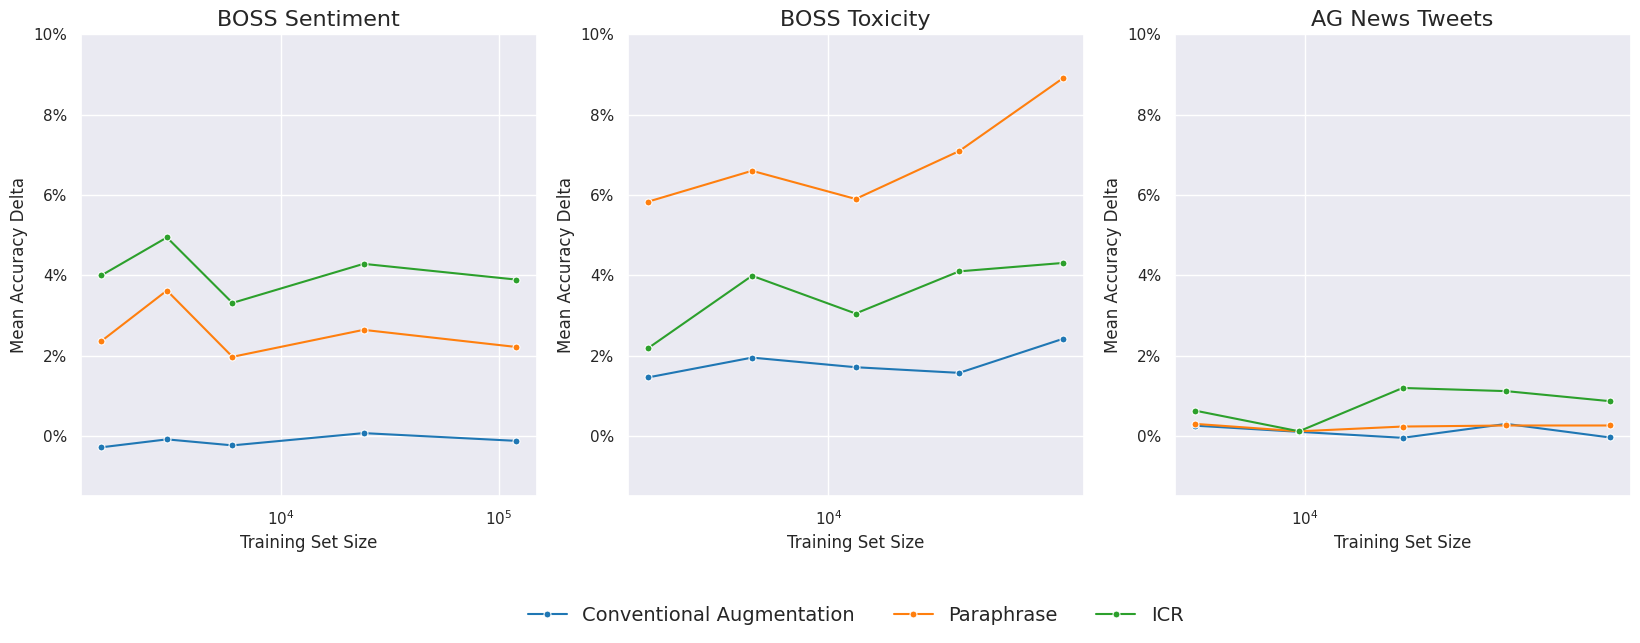

In [16]:
method_avg_delta = {}
for task_name in results:
    for data_count in results[task_name]:
        tta_perf_deltas = {}
        for tta_method in results[task_name][data_count]:
            for ood_shift in results[task_name][data_count][tta_method]:
                if tta_method not in tta_perf_deltas:
                    tta_perf_deltas[tta_method] = []

                shift_method_perf_deta = results[task_name][data_count][tta_method][ood_shift]["baseline_delta"]
                tta_perf_deltas[tta_method].append(shift_method_perf_deta)

        if task_name not in method_avg_delta:
            method_avg_delta[task_name] = {}

        method_avg_delta[task_name][data_count] = { tta_method: np.mean(tta_perf_deltas[tta_method]) for tta_method in tta_perf_deltas }
        baseline = np.mean([method_avg_delta[task_name][data_count]["Insert"], method_avg_delta[task_name][data_count]["Substitute"], method_avg_delta[task_name][data_count]["Translate"]])
        method_avg_delta[task_name][data_count]["Conventional Augmentation"] = baseline

# display(method_avg_delta)

pandas_form = {task_name: {} for task_name in results}
for task_name in pandas_form:
    for data_count in method_avg_delta[task_name]:
        for tta_method in ["Conventional Augmentation", "Paraphrase", "ICR"]:
            if data_count not in pandas_form[task_name]:
                pandas_form[task_name][data_count] = []

            pandas_form[task_name][data_count].append({
                "data_count": data_count,
                "tta_method": tta_method,
                "avg_delta": method_avg_delta[task_name][data_count][tta_method],
            })


fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, task_name in enumerate(["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]):
    df = pd.concat([pd.DataFrame(pandas_form[task_name][data_count]) for data_count in pandas_form[task_name]])
    sns.lineplot(data=df, x="data_count", y="avg_delta", hue="tta_method", ax=axes[i], marker="o", markersize=5)

    # set x label to Training Set Size
    axes[i].set_xlabel("Training Set Size")

    # lgo the x axis
    axes[i].set_xscale("log")
    # axes[i].set_xticks(df["data_count"].sort_values().unique().tolist())

    # create five equally spaced ticks between the min and max of the x axis
    # axes[i].set_xticks(np.linspace(df["data_count"].min(), df["data_count"].max(), 5))

    # set y label to Mean Absolute Accuracy Delta
    axes[i].set_ylabel("Mean Accuracy Delta")

    # make the y axis percents that go to the hundreds place
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize the y axis
    axes[i].set_ylim(-0.015, 0.1)

    title_text = {
        "BOSS_Sentiment": "BOSS Sentiment",
        "BOSS_Toxicity": "BOSS Toxicity",
        "AgNewsTweets": "AG News Tweets",
    }

    axes[i].set_title(title_text[task_name], fontsize=16)

    # se legend to the bottom left
    axes[i].legend(loc="lower right")

    # remove leegnd in not middle plot
    if i != 1:
        axes[i].get_legend().remove()
    else:
        # center below plot with no frame
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=5, frameon=False, fontsize=14)

# add padding
# plt.tight_layout(pad=0.5)
if not os.path.exists("../datasets/analysis/figures/"):
    os.makedirs("../datasets/analysis/figures/")
fig.savefig("../datasets/analysis/figures/method_analysis_data_ablation.png", bbox_inches="tight")

# OOD Analysis

In [17]:
sst5_data = inference_logs["BOSS_Sentiment_SST5_BERT_ICR"].to_pandas()
display(sst5_data.head(1))
display(sst5_data.shape)

toxigen_data = inference_logs["BOSS_Toxicity_Toxigen_BERT_ICR"].to_pandas()
display(toxigen_data.head(1))
display(toxigen_data.shape)

agt_data = inference_logs["AgNewsTweets_Tweets_BERT_ICR"].to_pandas()
display(agt_data.head(1))
display(agt_data.shape)

,outcome,original_text,augmentations,generations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,New Mistake,Too much of this well-acted but dangerously sl...,"[The movie, while well-acted, moves at a slow ...",[],0,2,0,9.676079,0.683401,0.43959,True,0.243811,"[0.14294172823429108, 0.0047321743331849575, 0...","[[0.017056243494153023, 0.008808363229036331, ...","[0.13664887845516205, 0.35321366786956787, 0.1..."


(1072, 15)

,outcome,original_text,augmentations,generations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,Unfixed Mistake,While some members of congress take principle...,[While some members of Congress maintain stron...,[],0,0,1,16.081046,0.000069,0.000071,False,-0.000003,"[0.9999945163726807, 5.425529252534034e-06]","[[0.9999943971633911, 5.54633652427583e-06], [...","[7.272665970958769e-05, 6.922210741322488e-05,..."


(944, 15)

,outcome,original_text,augmentations,generations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,Unchanged Correct,"""Just in: Afghanistan suspends vote counting &...","[Paraphrased Text Paraphrased Text, Afghanist...",[],0,0,0,2.044076,0.000425,0.00224,False,-0.001815,"[0.9997696280479431, 9.805672561924439e-06, 9....","[[1.7900685634231195e-05, 1.1557237939996412e-...","[0.0002792786981444806, 0.00011301346239633858..."


(7600, 15)

## Does TTA Effect Some Classes More Than Others?

In [18]:
sst5_data.value_counts(["label", "outcome"]).sort_index()

label  outcome          
0      NA                    10
       New Correct           29
       New Mistake            9
       Unchanged Correct    166
       Unfixed Mistake       68
1      NA                     1
       New Correct           24
       New Mistake            9
       Unchanged Correct    339
       Unfixed Mistake       27
2      NA                     9
       New Correct           46
       New Mistake           22
       Unchanged Correct    189
       Unfixed Mistake      124
Name: count, dtype: int64

In [39]:
ood_sentiment_icr_data = None
ood_toxicity_icr_data = None
ood_tweets_icr_data = None
for split_name in inference_logs:
    current_frame = inference_logs[split_name].to_pandas()
    current_frame["dataset"] = split_name

    if "Sentiment" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_sentiment_icr_data is None:
            ood_sentiment_icr_data = current_frame
        else:
            ood_sentiment_icr_data = pd.concat([ood_sentiment_icr_data, current_frame])

    if "Toxicity" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_toxicity_icr_data is None:
            ood_toxicity_icr_data = current_frame
        else:
            ood_toxicity_icr_data = pd.concat([ood_toxicity_icr_data, current_frame])

    if "Tweets" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_tweets_icr_data is None:
            ood_tweets_icr_data = current_frame
        else:
            ood_tweets_icr_data = pd.concat([ood_tweets_icr_data, current_frame])


display(ood_sentiment_icr_data.value_counts("dataset"))
display(ood_toxicity_icr_data.value_counts("dataset"))
display(ood_tweets_icr_data.value_counts("dataset"))

dataset
BOSS_Sentiment_SemEval_BERT_ICR     20624
BOSS_Sentiment_Dynasent_BERT_ICR     4320
BOSS_Sentiment_SST5_BERT_ICR         1072
Name: count, dtype: int64

dataset
BOSS_Toxicity_Toxigen_BERT_ICR     944
BOSS_Toxicity_AdvCivil_BERT_ICR    824
Name: count, dtype: int64

dataset
AgNewsTweets_Tweets_BERT_ICR    7600
Name: count, dtype: int64

In [44]:
# for each dataset, get the percent of examples that are unchanged vs new
sentiment_outcomes = sst5_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * sentiment_outcomes[sentiment_outcomes.index == "New Correct"].values[0] + sentiment_outcomes[sentiment_outcomes.index == "New Mistake"].values[0]
print(f"Sentiment: {new_predcitions_percent:.2f}% of examples are new predictions")

toxicity_outcomes = toxigen_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * toxicity_outcomes[toxicity_outcomes.index == "New Correct"].values[0] + toxicity_outcomes[toxicity_outcomes.index == "New Mistake"].values[0]
print(f"Toxicity: {new_predcitions_percent:.2f}% of examples are new predictions")

agt_outcomes = agt_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * agt_outcomes[agt_outcomes.index == "New Correct"].values[0] + agt_outcomes[agt_outcomes.index == "New Mistake"].values[0]
print(f"AGT: {new_predcitions_percent:.2f}% of examples are new predictions")

Sentiment: 9.27% of examples are new predictions
Toxicity: 5.15% of examples are new predictions
AGT: 1.98% of examples are new predictions


KeyError: 'Outcome'

<Figure size 640x480 with 0 Axes>

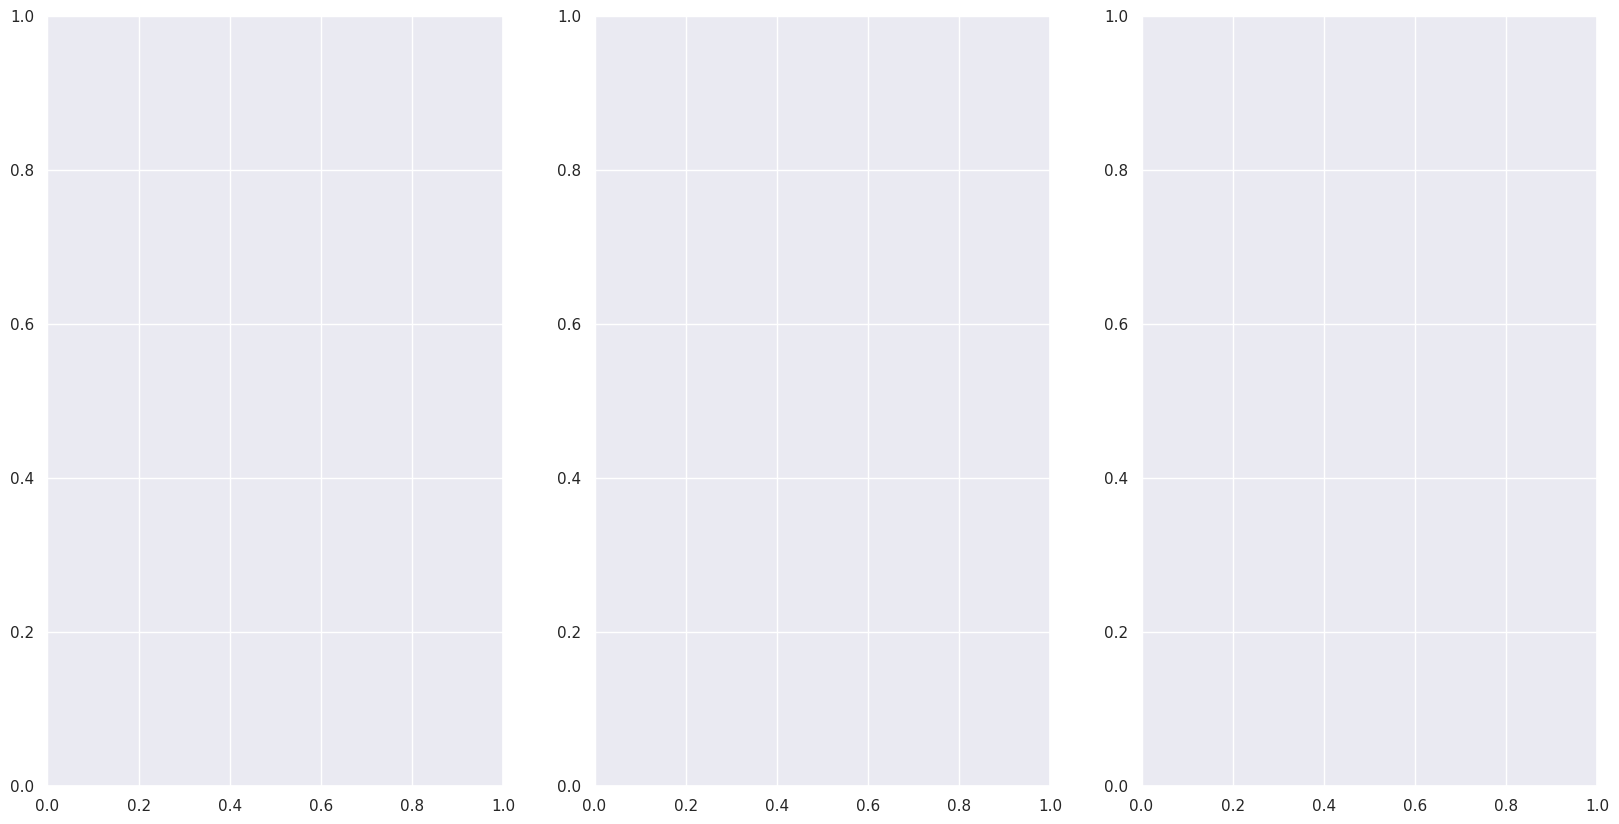

In [47]:
# clear plots
plt.clf()

# Create three histograms on one row
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sentiment_labels = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}
sentiment_corruptions_corrections = sentiment_outcomes[(sentiment_outcomes["Outcome"] == "New Correct") | (sentiment_outcomes["Outcome"] == "New Mistake")]
sentiment_corruptions_corrections.sort_values(by=["label", "Outcome"], inplace=True)
sentiment_corruptions_corrections["label"] = sentiment_corruptions_corrections["label"].apply(lambda l: sentiment_labels[l])
# sort values by Negative, Neutral, Positive in that order
sentiment_corruptions_corrections.sort_values(by=["label"], inplace=True, key=lambda x: x.map({"Negative": 0, "Neutral": 1, "Positive": 2}))
sns.histplot(data=sentiment_corruptions_corrections, x="label", hue="Outcome", multiple="dodge", shrink=.8, ax=axes[0])

toxicity_labels = {
    0: "Non-Toxic",
    1: "Toxic",
}
toxicity_corruptions_corrections = toxicity_outcomes[(toxicity_outcomes["Outcome"] == "New Correct") | (toxicity_outcomes["Outcome"] == "New Mistake")]
toxicity_corruptions_corrections.sort_values(by=["label", "Outcome"], inplace=True)
toxicity_corruptions_corrections["label"] = toxicity_corruptions_corrections["label"].apply(lambda l: toxicity_labels[l])
sns.histplot(data=toxicity_corruptions_corrections, x="label", hue="Outcome", multiple="dodge", shrink=.8, ax=axes[1])

agt_labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
agt_corruptions_corrections = agt_data[(agt_data["Outcome"] == "New Correct") | (agt_data["Outcome"] == "New Mistake")]
agt_corruptions_corrections.sort_values(by=["label", "Outcome"], inplace=True)
agt_corruptions_corrections["label"] = agt_corruptions_corrections["label"].apply(lambda l: agt_labels[l])
sns.histplot(data=agt_corruptions_corrections, x="label", hue="Outcome", multiple="dodge", shrink=.8, ax=axes[2])

axes[0].set_ylabel("Count", labelpad=20, fontsize=14)
axes[1].set_ylabel("")
axes[2].set_ylabel("")
axes[0].set_xlabel("SST-5", labelpad=20, fontsize=14)
axes[1].set_xlabel("toxicity", labelpad=20, fontsize=14)
axes[2].set_xlabel("AG News Tweets", labelpad=20, fontsize=14)

# set x labels above the plots
axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
axes[2].xaxis.set_label_position('top')

# Have a shared legend
axes[0].get_legend().remove()
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), labels=["Corruptions", "Corrections"], ncol=2, fancybox=False, frameon=False, fontsize=14)
axes[2].get_legend().remove()


# add padding
fig.tight_layout(pad=3.0)
fig.savefig("../datasets/analysis/figures/corruptions_corrections_histograms.png", bbox_inches='tight', dpi=300)



In [22]:
inference_logs["BOSS_Sentiment_ID_T5_ICR"]

Dataset({
    features: ['outcome', 'original_text', 'augmentations', 'generations', 'original_predicted_class', 'tta_predicted_class', 'label', 'tta_inference_latency', 'original_prediction_entropy', 'tta_prediction_entropy', 'prediction_entropy_decreased', 'prediction_entropy_decrease', 'tta_mean_class_probs', 'tta_all_class_probs', 'tta_all_class_entropy'],
    num_rows: 38904
})

## Heatmap Correlations

In [23]:
# # API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
# from scipy.stats import pearsonr as pearson_correlation

# # API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
# from scipy.stats import spearmanr as spearman_correlation

# from scipy.stats import pointbiserialr

# # Paper - https://arxiv.org/abs/1909.10140
# # API - https://swarnakumar.github.io/xicorpy/xi/
# # from xicorpy import compute_xi_correlation as xi_correlation

# from sklearn import preprocessing

# conditional_test_outputs = dict()

# outcome_map = {
#         "New Correct": 3,
#         "New Mistake": 2,
#         "Unchanged Correct": 1,
#         "Unfixed Mistake": 0,
#         "NA": None
#     }
# reverse_outcome_map = {v: k for k, v in outcome_map.items()}

# for split in ["BOSS_Sentiment_ID_BERT_ICR", "BOSS_Sentiment_SST5_BERT_ICR"]:
#     correlation_records = []

#     for outcome in outcome_map.values():
#         if outcome is None:
#             continue
#         for correlation_metric in ["original_prediction_entropy", "tta_prediction_entropy", "prediction_entropy_decrease"]:
#             study_frame = inference_logs[split].to_pandas()
#             study_frame["outcome"] = study_frame["outcome"].apply(lambda o: int(outcome_map[o] == outcome))
#             study_frame.dropna(inplace=True)
#             correlation_results = pointbiserialr(study_frame[correlation_metric], study_frame["outcome"])
#             correlation_records.append({
#                 "outcome": reverse_outcome_map[outcome],
#                 f"{correlation_metric}_correlation": correlation_results[0],
#                 f"{correlation_metric}_p-value": correlation_results[1],
#             })

#     print(f"Split: {split}")
#     display(pd.DataFrame(correlation_records).groupby("outcome").mean())


## Calculate Optimal ID Entropy Thresholds

In [24]:
def should_augment_entropy(threshold, row):
    return row["tta_prediction_entropy"] > threshold


def get_entropy_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_entropy(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


def should_augment_softmax(threshold, row):
    try:
        return row["tta_all_class_probs"][-1].max() < threshold
    except:
        return False


def get_max_softmax_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_softmax(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


optimal_entropy_thresholds = {}
optimal_softmax_thresholds = {}
thresholds = np.arange(0.1, 1, 0.05)

for split in tqdm([dataset for dataset in inference_logs if "BERT" in dataset]):
    best_entropy_threshold = None
    best_softmax_threshold = None
    split_frame = inference_logs[split].to_pandas()
    sample_frame = None
    unique_predicted_classes = [class_label for class_label in split_frame["tta_predicted_class"].unique() if class_label != -1] 
    for class_prediction in unique_predicted_classes:
        sample_size = 200 // len(unique_predicted_classes)
        class_sample_frame = split_frame[split_frame["tta_predicted_class"] == class_prediction].sample(sample_size, random_state=42)
        if sample_frame is None:
            sample_frame = class_sample_frame
        else:
            sample_frame = pd.concat([sample_frame, class_sample_frame])
    
    for threshold in thresholds:
        accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, sample_frame)
        beta = 1/20
        rate_term = 1 - llm_call_rate
        threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
        # if best_entropy_threshold is None or accuracy > best_entropy_threshold["accuracy"]:
        if best_entropy_threshold is None or threshold_score > best_entropy_threshold["score"]:
            best_entropy_threshold = {
                "threshold": threshold,
                "accuracy": accuracy,
                "score": threshold_score,
                "llm_call_rate": f"{llm_call_rate:.2f}%",
            }
        
        accuracy, llm_call_rate = get_max_softmax_threshold_accuracy(threshold, sample_frame)
        threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
        # if best_softmax_threshold is None or accuracy > best_softmax_threshold["accuracy"]:
        if best_softmax_threshold is None or threshold_score > best_softmax_threshold["score"]:
            best_softmax_threshold = {
                "threshold": threshold,
                "accuracy": accuracy,
                "score": threshold_score,
                "llm_call_rate": f"{llm_call_rate:.2f}%",
            }

    optimal_entropy_thresholds[split] = best_entropy_threshold
    optimal_softmax_thresholds[split] = best_softmax_threshold

print(json.dumps(optimal_entropy_thresholds, indent=4))
# print(json.dumps(optimal_softmax_thresholds, indent=4))


100%|██████████| 223/223 [01:39<00:00,  2.24it/s]

{
    "BOSS_Sentiment_ID_BERT_Insert": {
        "threshold": 0.9500000000000003,
        "accuracy": 0.7424242424242424,
        "score": 0.7428730563899766,
        "llm_call_rate": "0.02%"
    },
    "BOSS_Sentiment_ID_BERT_Substitute": {
        "threshold": 0.9500000000000003,
        "accuracy": 0.7575757575757576,
        "score": 0.7579892492173194,
        "llm_call_rate": "0.03%"
    },
    "BOSS_Sentiment_ID_BERT_Translate": {
        "threshold": 0.9500000000000003,
        "accuracy": 0.7878787878787878,
        "score": 0.7882719409665517,
        "llm_call_rate": "0.02%"
    },
    "BOSS_Sentiment_ID_BERT_Paraphrase": {
        "threshold": 0.9500000000000003,
        "accuracy": 0.7929292929292929,
        "score": 0.7933148158271948,
        "llm_call_rate": "0.02%"
    },
    "BOSS_Sentiment_ID_BERT_ICR": {
        "threshold": 0.9500000000000003,
        "accuracy": 0.7626262626262627,
        "score": 0.763040352981013,
        "llm_call_rate": "0.03%"
    },
    "B

### Selective Augmentation

In [25]:
def set_tta_preds(row):
    if row["generations"] is not None and len(row["generations"]) > 0:
        return row["generations"][:5]
    
    if row["tta_all_class_probs"] is None:
        return None

    all_probs = row["tta_all_class_probs"][:5]
    arg_maxes = [prob_dist.argmax() for prob_dist in all_probs]
    return arg_maxes

In [26]:
model = "BERT"
id_logs = [split for split in inference_logs if f"ID_{model}" in split]
split_names = [split for split in inference_logs if f"{model}" in split and f"ID_{model}" not in split]
perf_records = []

# display(id_logs)
# display(split_names)
for split_name in tqdm(id_logs + split_names):
    split_logs = inference_logs[split_name].to_pandas()

    perf_records.append({
        "split": split_name,
        "tta": "None",
        "accuracy": classification_report(split_logs["label"], split_logs["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    # perf_records.append({
    #     "split": split_name,
    #     "tta": "100% AR Mean",
    #     "accuracy": classification_report(split_logs["label"], split_logs["tta_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    # })

    # split_logs["vote peds"] = split_logs.apply(lambda row: set_tta_preds(row), axis=1)
    # vote_counts = split_logs["vote peds"].apply(lambda preds: -1 if preds is None else np.bincount(preds, minlength=len(preds)))
    # majority_judgments = [np.argmax(vote_dist) for vote_dist in vote_counts]
    # perf_records.append({
    #     "split": split_name,
    #     "tta": "100% AR Vote",
    #     "accuracy": classification_report(split_logs["label"], majority_judgments, digits=4, zero_division=0, output_dict=True)["accuracy"],
    # })

    # majority_counts = [np.max(vote_dist) for vote_dist in vote_counts]
    # split_logs["vote counts"] = majority_counts
    # # print(split_name)
    # # display(split_logs[["outcome", "vote counts"]].groupby("outcome").describe())
    # perf_records.append({
    #     "split": split_name,
    #     "tta": "100% AR Vote",
    #     "accuracy": classification_report(split_logs["label"], majority_judgments, digits=4, zero_division=0, output_dict=True)["accuracy"],
    # })

    # selective_predictions = split_logs.apply(lambda row: row["tta_predicted_class"] if row["original_predicted_class"] not in labels_list else row["original_predicted_class"], axis=1)
    # perf_records.append({
    #     "split": split_name,
    #     "tta": "class-based",
    #     "accuracy": classification_report(split_logs["label"], selective_predictions, digits=4, zero_division=0, output_dict=True)["accuracy"],
    #     "augmentation_rate": sum(~split_logs["original_predicted_class"].isin(labels_list)) / len(split_logs),
    # })

    optimal_entropy_threshold = optimal_entropy_thresholds[split_name]["threshold"]
    accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, split_logs)[0]
    perf_records.append({
        "split": split_name,
        "tta": "entropy-based",
        "accuracy": accuracy,
        "augmentation_rate": split_logs.apply(lambda row: should_augment_entropy(optimal_entropy_threshold, row), axis=1).sum() / len(split_logs),
    })

    # optimal_softmax_threshold = optimal_softmax_thresholds[split_name]["threshold"]
    # accuracy = get_max_softmax_threshold_accuracy(optimal_softmax_threshold, split_logs)[0]
    # perf_records.append({
    #     "split": split_name,
    #     "tta": "softmax-based",
    #     "accuracy": accuracy,
    #     "augmentation_rate": split_logs.apply(lambda row: should_augment_softmax(optimal_softmax_threshold, row), axis=1).sum() / len(split_logs),
    # })


100%|██████████| 223/223 [00:42<00:00,  5.29it/s]


In [27]:
results_frame = pd.DataFrame(perf_records)
results_frame["Dataset"] = results_frame["split"].apply(lambda s: s.split("_")[-4])
results_frame["Distribution"] = results_frame["split"].apply(lambda s: s.split("_")[-3])
results_frame["Model"] = results_frame["split"].apply(lambda s: s.split("_")[-2])
results_frame["TTA Method"] = results_frame["split"].apply(lambda s: s.split("_")[-1])
results_frame["Baseline Delta"] = results_frame.apply(lambda row: row["accuracy"] - results_frame[(results_frame["split"] == row["split"]) & (results_frame["tta"] == "None")]["accuracy"].values[0], axis=1)
results_frame.drop(columns=["split"], inplace=True)
results_frame.rename(columns={"tta": "Selective Method", "accuracy": "Accuracy", "augmentation_rate": "Augmentation Rate"}, inplace=True)

aggregated_results = results_frame.groupby(["Dataset", "Distribution", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "Distribution", "Model", "TTA Method", "Accuracy"], ascending=False)

print("Overall Results")
# display(aggregated_results)

# Average each TTA Method and Selective Method over distributions
results_frame["ID"] = results_frame["Distribution"].apply(lambda d: "ID" in d)
results_frame.drop(columns=["Distribution", "Accuracy"], inplace=True)
results_frame = results_frame[["Dataset", "ID", "Model", "TTA Method", "Selective Method", "Baseline Delta", "Augmentation Rate"]]
aggregated_results = results_frame.groupby(["Dataset", "ID", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "ID", "Model", "TTA Method", "Baseline Delta"], ascending=False)
print("Average Results")
for dataset in ["Sentiment", "Toxicity", "AgNewsTweets"]:
    for tta_method in ["Insert", "Substitute", "Translate", "Paraphrase", "ICR"]:
    # for tta_method in ["ICR"]:
        print(f"Dataset: {dataset}, TTA Method: {tta_method}")
        # display(aggregated_results.loc[dataset, :, :, tta_method, :])
        # only show entropy-based
        display(aggregated_results.loc[dataset, :, :, tta_method, "entropy-based"])

Overall Results
Average Results
Dataset: Sentiment, TTA Method: Insert


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,0.03,1.42
False,BERT,-0.27,30.51


Dataset: Sentiment, TTA Method: Substitute


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.22,2.76
False,BERT,-0.21,36.98


Dataset: Sentiment, TTA Method: Translate


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.33,1.86
False,BERT,0.23,26.29


Dataset: Sentiment, TTA Method: Paraphrase


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.13,1.24
False,BERT,1.90,37.59


Dataset: Sentiment, TTA Method: ICR


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.03,1.03
False,BERT,4.39,54.34


Dataset: Toxicity, TTA Method: Insert


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,0.46,3.17
False,BERT,0.05,1.84


Dataset: Toxicity, TTA Method: Substitute


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,0.0,0.00
False,BERT,-0.0,6.94


Dataset: Toxicity, TTA Method: Translate


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,0.01,1.14
False,BERT,3.42,10.08


Dataset: Toxicity, TTA Method: Paraphrase


,,Baseline Delta,Augmentation Rate
ID,Model,,
False,BERT,3.2,10.72


Dataset: Toxicity, TTA Method: ICR


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,0.49,2.83
False,BERT,4.26,18.19


Dataset: AgNewsTweets, TTA Method: Insert


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.01,0.84
False,BERT,0.12,2.42


Dataset: AgNewsTweets, TTA Method: Substitute


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,0.01,2.38
False,BERT,0.13,2.11


Dataset: AgNewsTweets, TTA Method: Translate


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.08,0.62
False,BERT,0.01,2.30


Dataset: AgNewsTweets, TTA Method: Paraphrase


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.47,1.80
False,BERT,0.00,0.13


Dataset: AgNewsTweets, TTA Method: ICR


,,Baseline Delta,Augmentation Rate
ID,Model,,
True,BERT,-0.49,1.84
False,BERT,0.53,4.96
